<a href="https://colab.research.google.com/github/Castro-Ian/Web-Threat-Interactions/blob/main/webthreatinteractions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the data into a DataFrame
data = pd.read_csv("/CloudWatch_Traffic_Web_Attack.csv")

# Display the first few rows of the DataFrame to understand its structure
print(data.head())

   bytes_in  bytes_out         creation_time              end_time  \
0      5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
1     30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
2     28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
3     30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
4      6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_name  \
0  10.138.69.97  Suspicious Web Traffic  

In [ ]:
# Convert 'creation_time' to datetime format
data['creation_time'] = pd.to_datetime(data['creation_time'])

# Set 'creation_time' as the index
data.set_index('creation_time', inplace=True)


In [ ]:
# Check if 'creation_time' is still a column
if 'creation_time' in data.columns:
    # Convert 'creation_time' to datetime format if it's still a column
    data['creation_time'] = pd.to_datetime(data['creation_time'])

    # Set 'creation_time' as the index
    data.set_index('creation_time', inplace=True)
else:
    print("`creation_time` is already the index.")

`creation_time` is already the index.


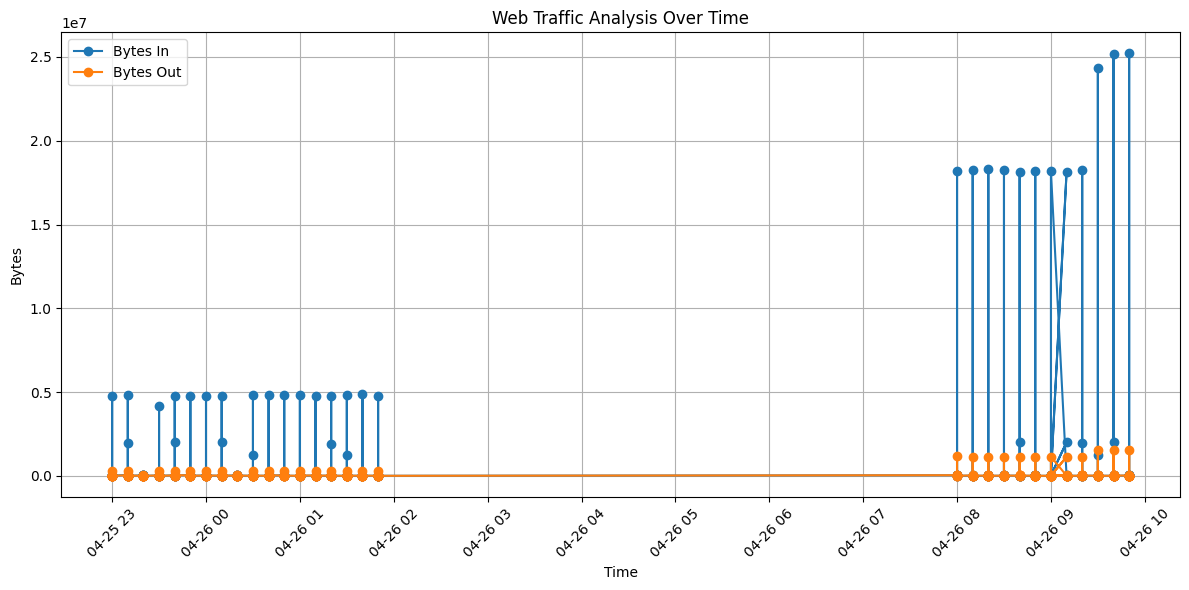

In [ ]:
# Plotting web traffic over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['bytes_in'], label='Bytes In', marker='o')
plt.plot(data.index, data['bytes_out'], label='Bytes Out', marker='o')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Remove duplicate rows
df_unique = data.drop_duplicates()

# Convert time-related columns to datetime format
df_unique['end_time'] = pd.to_datetime(df_unique['end_time'])
df_unique['time'] = pd.to_datetime(df_unique['time'])

# Standardize text data
df_unique['src_ip_country_code'] = df_unique['src_ip_country_code'].str.upper()

# Feature engineering: Calculate duration of connection
# Use .index to access the 'creation_time' which is now the index
df_unique['duration_seconds'] = (df_unique['end_time'] - df_unique.index).dt.total_seconds()

In [ ]:
# StandardScaler for numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_unique[['bytes_in', 'bytes_out', 'duration_seconds']])
scaled_columns = ['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds']

# OneHotEncoder for categorical features
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df_unique[['src_ip_country_code']])
encoded_columns = encoder.get_feature_names_out(['src_ip_country_code'])

# Convert numpy arrays back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=scaled_columns, index=df_unique.index)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=df_unique.index)

# Concatenate all the data back together
transformed_df = pd.concat([df_unique, scaled_df, encoded_df], axis=1)

# Display the transformed data
print("Top 10 Transformed Datasets Information:")
print(transformed_df.head(10))


Top 10 Transformed Datasets Information:
                           bytes_in  bytes_out                  end_time  \
creation_time                                                              
2024-04-25 23:00:00+00:00      5602      12990 2024-04-25 23:10:00+00:00   
2024-04-25 23:00:00+00:00     30912      18186 2024-04-25 23:10:00+00:00   
2024-04-25 23:00:00+00:00     28506      13468 2024-04-25 23:10:00+00:00   
2024-04-25 23:00:00+00:00     30546      14278 2024-04-25 23:10:00+00:00   
2024-04-25 23:00:00+00:00      6526      13892 2024-04-25 23:10:00+00:00   
2024-04-25 23:00:00+00:00      3906       3488 2024-04-25 23:10:00+00:00   
2024-04-25 23:00:00+00:00     17748      29208 2024-04-25 23:10:00+00:00   
2024-04-25 23:00:00+00:00   4767917     291520 2024-04-25 23:10:00+00:00   
2024-04-25 23:00:00+00:00     10538      15514 2024-04-25 23:10:00+00:00   
2024-04-25 23:00:00+00:00      9656       6380 2024-04-25 23:10:00+00:00   

                                    src_ip src

Correlation Matrix for Numeric Columns:
                         bytes_in  bytes_out  response.code  dst_port  \
bytes_in                 1.000000   0.997705            NaN       NaN   
bytes_out                0.997705   1.000000            NaN       NaN   
response.code                 NaN        NaN            NaN       NaN   
dst_port                      NaN        NaN            NaN       NaN   
duration_seconds              NaN        NaN            NaN       NaN   
scaled_bytes_in          1.000000   0.997705            NaN       NaN   
scaled_bytes_out         0.997705   1.000000            NaN       NaN   
scaled_duration_seconds       NaN        NaN            NaN       NaN   
src_ip_country_code_AE  -0.070559  -0.072452            NaN       NaN   
src_ip_country_code_AT  -0.081670  -0.081777            NaN       NaN   
src_ip_country_code_CA  -0.166488  -0.159587            NaN       NaN   
src_ip_country_code_DE  -0.095333  -0.090001            NaN       NaN   
src_ip_coun

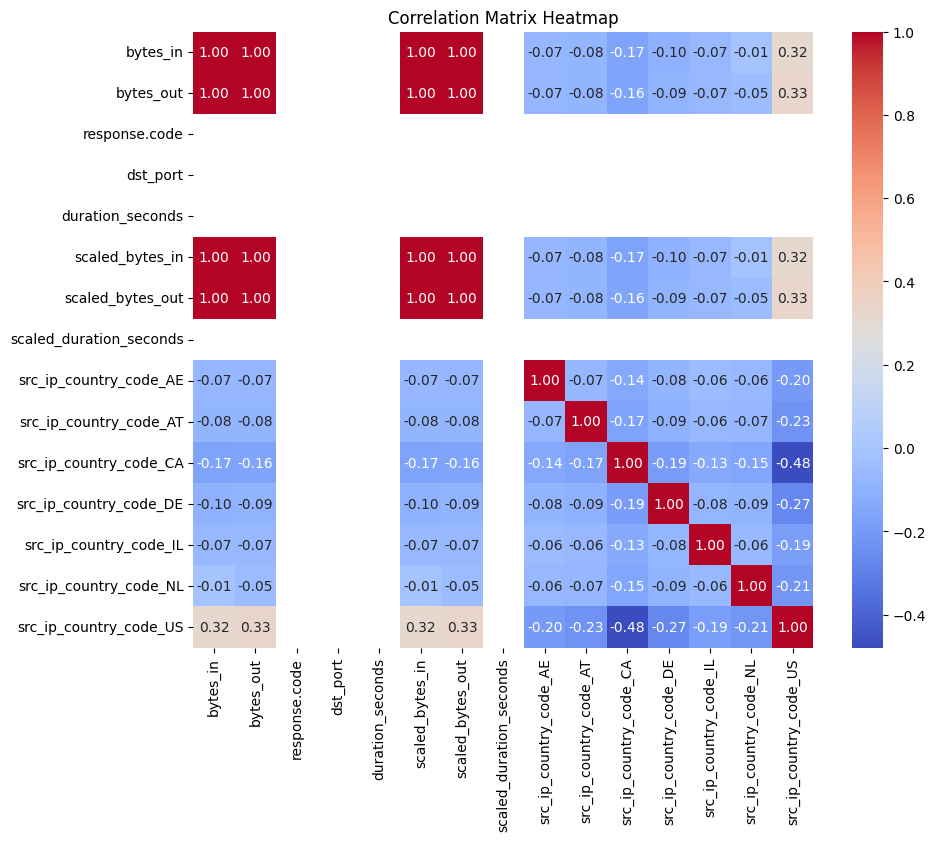

In [ ]:
# Compute correlation matrix for numeric columns only
numeric_df = transformed_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix_numeric = numeric_df.corr()

# Display the correlation matrix
print("Correlation Matrix for Numeric Columns:")
print(correlation_matrix_numeric)

# Heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

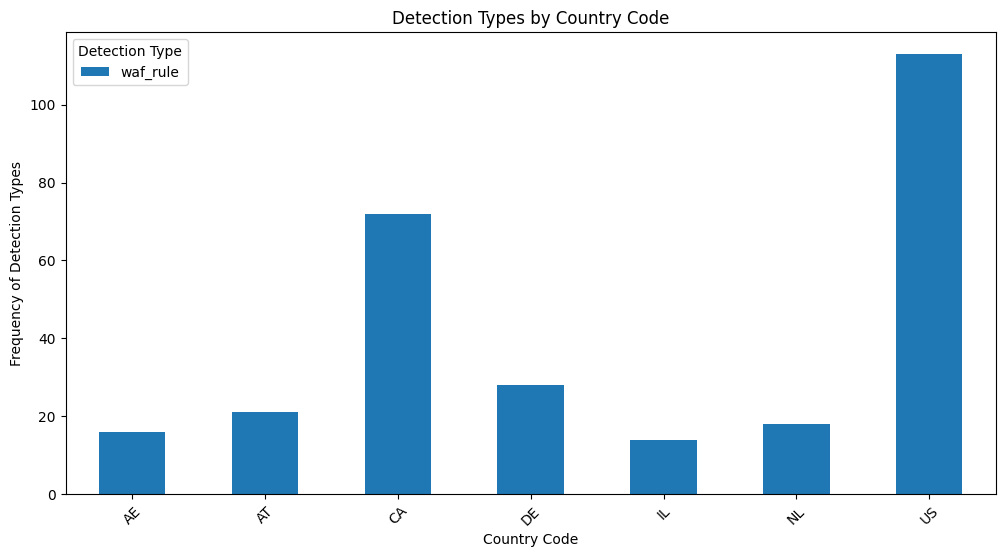

In [ ]:
# Ensure 'detection_types' exists in transformed_df
if 'detection_types' in transformed_df.columns:
    detection_types_by_country = pd.crosstab(transformed_df['src_ip_country_code'], transformed_df['detection_types'])
    detection_types_by_country.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title('Detection Types by Country Code')
    plt.xlabel('Country Code')
    plt.ylabel('Frequency of Detection Types')
    plt.xticks(rotation=45)
    plt.legend(title='Detection Type')
    plt.show()
else:
    print("Column 'detection_types' not found in transformed_df")

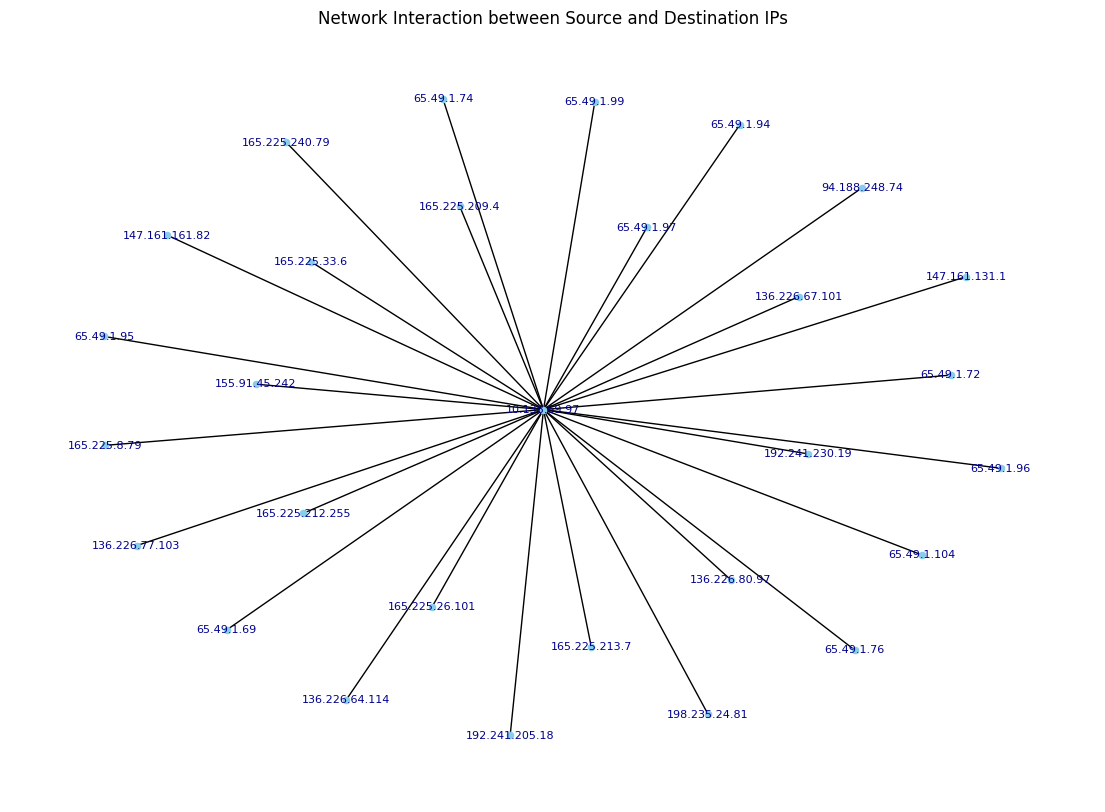

In [ ]:
# Create a graph
G = nx.Graph()

# Ensure 'src_ip' and 'dst_ip' exist in data
if 'src_ip' in data.columns and 'dst_ip' in data.columns:
    # Add edges from source IP to destination IP
    for idx, row in data.iterrows():
        G.add_edge(row['src_ip'], row['dst_ip'])

    # Draw the network graph
    plt.figure(figsize=(14, 10))
    nx.draw_networkx(G, with_labels=True, node_size=20, font_size=8, node_color='skyblue', font_color='darkblue')
    plt.title('Network Interaction between Source and Destination IPs')
    plt.axis('off')
    plt.show()
else:
    print("Columns 'src_ip' and/or 'dst_ip' not found in data")

In [ ]:
# Encode detection_types into binary labels
data['is_suspicious'] = (data['detection_types'] == 'waf_rule').astype(int)

# Features and labels
X = data[['bytes_in', 'bytes_out']].values
y = data['is_suspicious'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/10
5/5 [==============================] - 2s 108ms/step - loss: 0.6677 - accuracy: 0.7643 - val_loss: 0.5877 - val_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 0s 25ms/step - loss: 0.5807 - accuracy: 0.9809 - val_loss: 0.4860 - val_accuracy: 1.0000
Epoch 3/10
5/5 [==============================] - 0s 23ms/step - loss: 0.4893 - accuracy: 1.0000 - val_loss: 0.4039 - val_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 0s 38ms/step - loss: 0.4112 - accuracy: 1.0000 - val_loss: 0.3253 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 0s 31ms/step - loss: 0.3301 - accuracy: 1.0000 - val_loss: 0.2499 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 0s 28ms/step - loss: 0.2445 - accuracy: 1.0000 - val_loss: 0.1812 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 0s 22ms/step - loss: 0.1729 - accuracy: 1.0000 - val_loss: 0.1247 - val_accuracy: 1.0000
Epoch 8/10
5/5 [==========

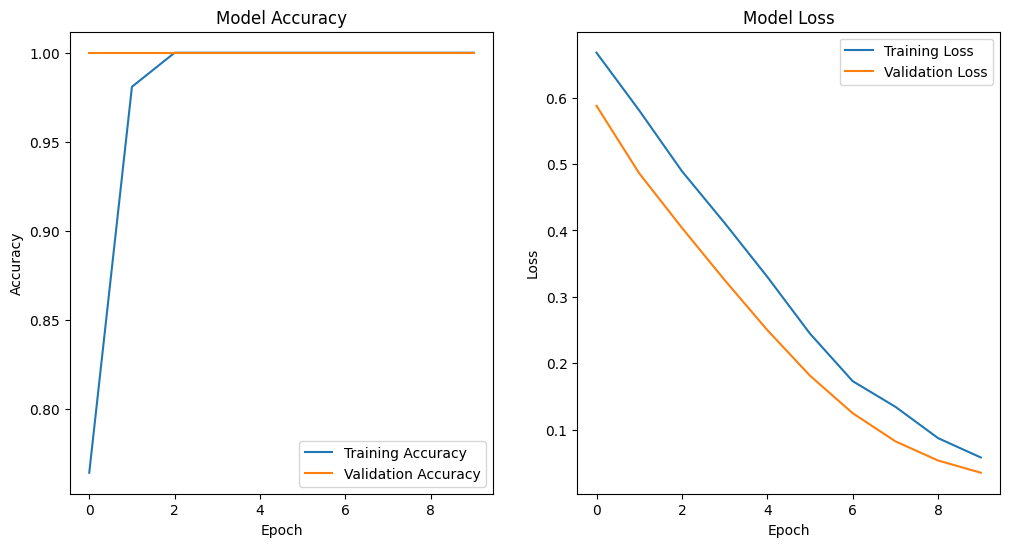

In [ ]:
# Plotting the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
